---
### Project - Road Image Segmentation for AD/ADAS related applications
---

Check Python Version 

In [1]:
from platform import python_version_tuple

assert (
    python_version_tuple()[:2] == ("3", "11")
), "You are not running Python 3.11. Make sure to run Python through the course Conda environment."

Verify the package requirements

In [2]:
from importlib.util import find_spec

packages_to_find = ["numpy", "matplotlib", "pandas", "seaborn", "torch", "torchinfo",
                    "torchvision", "cv2", "sklearn", "segmentation_models_pytorch"]
all_found = True
for pkg in packages_to_find:
    if find_spec(pkg) is None:
        all_found = False
        raise ImportError(
            f"There was an error importing: [{pkg}]\n Please make sure you followed all instructions correctly."
        )

if all_found:
    print("All modules have been imported successfully.")

All modules have been imported successfully.


---
# Imports

In [3]:
# Standard Libraries and dealing with files
import os
import random
import glob
import shutil     
import numpy as np
import pandas as pd
import scipy
from scipy import misc
from pathlib import Path
from itertools import chain
from typing import Callable, Union

# Data Visualization and Image Processing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from PIL import Image, ImageChops

# PyTorch Modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchinfo import summary
from torchvision import models
import segmentation_models_pytorch as smp
from tqdm.auto import tqdm 

# Sci-kit-Learn Modules
from sklearn.model_selection import train_test_split                    # For splitting the data
from sklearn.datasets import fetch_openml                               # For accessing datasets from the OpenML database
from sklearn.preprocessing import StandardScaler                        # For Pre-processing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay    # For Confusion Matrix

# Others
import warnings
# warnings.filterwarnings("ignore")


# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# from torchvision.transforms import Compose, ToTensor, Resize, Normalize
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# from torchvision import models
# import glob
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import random

# Dataset Directories

In [4]:
# SAMPLE DATASET
image_dir = '/DML/Datasets/Road_Segment/images'
mask_dir = '/DML/Datasets/Road_Segment/masks'

# KITTI ROAD DATASET
kitti_image_dir = "/DML/Datasets/KITTI_ROAD/training/image_2"
kitti_mask_dir = "/DML/Datasets/KITTI_ROAD/training/gt_image_2"


# Dataset Classes

Sample Dataset

In [5]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

Kitti Road Dataset

Total Images = 289
Total Masks/Labels = 289
Image Dimension: (1242, 375)
Mask/Label Dimension: (1242, 375)


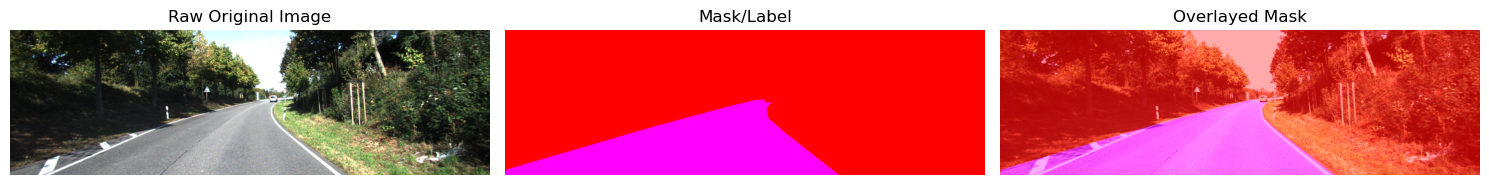

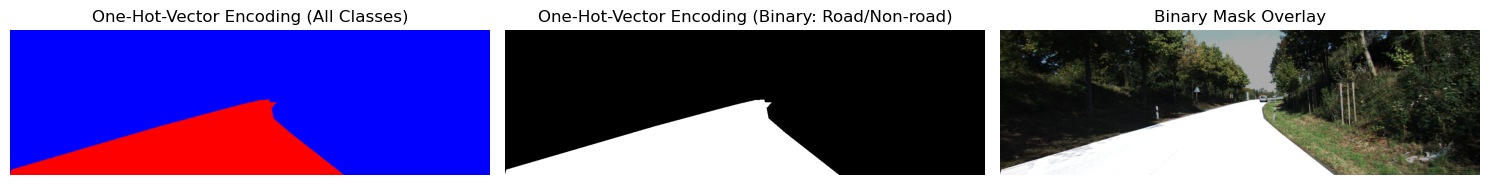

In [6]:
# Extracting the path of the data
def extract_path(img_path, mask_path, img_format = None, label_format = None, label_filter = None):

    # Load/Sort - Images and Masks/Labels
    img_files = sorted(list(Path(img_path).glob(img_format)))
    label_files = sorted(list(Path(mask_path).glob(label_format)))
    
    # Filter for 'road' class to match images and masks (Since images and labels count mis-matches)
    if label_filter:
        label_files = [file for file in label_files if label_filter in os.path.basename(file)]
    return img_files, label_files

# One-hot-encoding - Raw Data
def oh_encoding(label_array, img, dataset = 'kitti'):

        # Classes
        road_label = np.array([255, 0, 255])    # class: road
        non_road_label = np.array([255, 0, 0])  # class: non-road
        other_road_label = np.array([0, 0, 0])  # class: other/opposite road

        # One-Hot-Encoding (ohve)
        oh_label = np.zeros_like(label_array)
        oh_label[:, :, 0] = np.all(label_array == road_label, axis = 2).astype(np.uint8)
        oh_label[:, :, 1] = np.all(label_array == other_road_label, axis = 2).astype(np.uint8)
        oh_label[:, :, 2] = np.all(label_array == non_road_label, axis = 2).astype(np.uint8)

        # Binary Encoding (Road/Non-road)
        binary_label = (1 - np.all(label_array == non_road_label, axis = 2)).astype(np.uint8)
        # binary_label = ((oh_label[:, :, 0] == 1)).astype(np.uint8)  # Road == 1
    
        # Plotting
        plt.figure(figsize = (15, 5))

        # One-Hot-Encoded Image (All classes)
        plt.subplot(1, 3, 1)
        plt.imshow(oh_label * 255)
        plt.title("One-Hot-Vector Encoding (All Classes)")
        plt.axis('off')

        # Binary Mask/Label (Class: Road and Non-road)
        plt.subplot(1, 3, 2)
        plt.imshow(binary_label * 255, cmap = 'gray')
        plt.title("One-Hot-Vector Encoding (Binary: Road/Non-road)")
        plt.axis('off')

        # Overlay Binary Mask on the Original Raw Image
        binary_label_img = Image.fromarray(binary_label * 255)
        overlay_binary = ImageChops.add(img, binary_label_img.convert("RGB"), scale=1.5)
        plt.subplot(1, 3, 3)
        plt.imshow(overlay_binary)
        plt.title("Binary Mask Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Visualization - Raw Data
def visualize_data(img_files, mask_files, overlay = False, one_hot_encode = False, dataset = None):
    
    idx = random.randint(0, len(img_files) - 1)
    img = Image.open(img_files[idx])
    mask = Image.open(mask_files[idx])
    
    print(f"Image Dimension: {img.size}")
    print(f"Mask/Label Dimension: {mask.size}")
    
    img_np = np.array(img)
    mask_np = np.array(mask)

    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Raw Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Raw Original Image")
    plt.axis('off')
    
    # Mask/Label
    plt.subplot(1, 3, 2)
    plt.imshow(mask_np)
    plt.title("Mask/Label")
    plt.axis('off')
    
    # Overlay Mask/Label on the Original Raw Image
    if overlay:
        mask = mask.resize(img.size)  # Ensure: mask dimension == image dimension
        overlay_img = ImageChops.add(img, mask, scale = 1.5)
        plt.subplot(1, 3, 3)
        plt.imshow(overlay_img)
        plt.title("Overlayed Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # To perform one-hot encoding
    if one_hot_encode:
        oh_encoding(mask_np, img, dataset = dataset)

# Processing
def process_dataset(img_dir, mask_dir, img_format = "*.png", label_format = "*.png",
                    label_filter = None, overlay = False, one_hot_encode = False, dataset = None):
    
    img_files, label_files = extract_path(img_dir, mask_dir, img_format, label_format, label_filter)  # Get image and label paths
    print(f"Total Images = {len(img_files)}")           # Print Total Image Count
    print(f"Total Masks/Labels = {len(label_files)}")   # Print Total Mask/Label Count
    visualize_data(img_files, label_files, overlay = overlay, one_hot_encode = one_hot_encode, dataset = dataset) # Visualize data

# Calling to visualize
process_dataset(kitti_img_dir, kitti_mask_dir, img_format = "*.png", label_format = "*.png", 
                label_filter = "road", overlay = True, one_hot_encode = True, dataset = 'kitti')

# Model Architectures

UNet

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Final output
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)

        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)

        # Bottleneck
        bottleneck = self.bottleneck(enc2_pool)

        # Decoder
        up1 = self.upconv1(bottleneck)
        dec1 = self.dec1(torch.cat([up1, enc2], dim=1))

        up2 = self.upconv2(dec1)
        dec2 = self.dec2(torch.cat([up2, enc1], dim=1))

        # Final layer
        return torch.sigmoid(self.final(dec2))
    
# Our UNet Model
UNET_MODEL = UNet()
print(UNET_MODEL)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec1): Sequential(
    (0): Conv2d(25

VGGNet

In [8]:
# Load pretrained VGG16 and extract the convolutional layers (encoder)
# vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
# vgg16 = models.vgg16_bn(pretrained=True)

# Load model and manually load the downloaded weights
vgg16 = models.vgg16()
vgg16.load_state_dict(torch.load("/DML/vgg16-397923af.pth"))

print(vgg16.classifier)

class VGGBackboneUNet(nn.Module):
    def __init__(self):
        super(VGGBackboneUNet, self).__init__()
        
        # Load pretrained VGG16 and extract the convolutional layers (encoder)
        # vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # vgg16 = models.vgg16_bn(pretrained=True)

        # Load model and manually load the downloaded weights
        vgg16 = models.vgg16()
        vgg16.load_state_dict(torch.load("/DML/vgg16-397923af.pth"))

        self.encoder = vgg16.features
        
        # Define decoder layers (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Upconv 1 (from 32x32 -> 64x64)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upconv 2 (from 64x64 -> 128x128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # Upconv 3 (from 128x128 -> 256x256)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),                        # Final output (binary map)
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=True)  # Resize to 512x512
        )
    
    def forward(self, x):
        # Encode using VGG16 (backbone)
        x = self.encoder(x)
        
        # Decode to produce segmentation map
        x = self.decoder(x)
        
        # No activation (e.g., sigmoid) here since we will use BCEWithLogitsLoss
        return x
    
# Our Model
VGG_MODEL = VGGBackboneUNet()
print(VGG_MODEL)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
VGGBackboneUNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), st

# Pre-processing

UNet Model

In [10]:
img_size_unet = (512, 512)
batch_size_unet = 64 

transform_unet = Compose([Resize(img_size_unet), ToTensor()])

VGG16 Model

In [11]:
# Normalization Standards for VGG16 Models
mean_vgg = [0.485, 0.456, 0.406]
std_vgg = [0.229, 0.224, 0.225]
img_size_vgg = (224, 224)
batch_size_vgg = 16 

transform_vgg = Compose([Resize(img_size_vgg), ToTensor(), Normalize(mean = mean_vgg, std = std_vgg)])

# Loading the data

Sample Dataset

In [ ]:
# dataset = RoadSegmentationDataset(image_dir, mask_dir, transform=transform_unet)
dataset = RoadSegmentationDataset(image_dir, mask_dir, transform=transform_vgg)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(f"Size of the Training Data: {train_size}")
print(f"Size of the Validation Data: {val_size}")

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size_vgg, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_vgg, shuffle=False)


# Training

In [21]:
# Instantiate the model, define the loss and optimizer
model = UNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
early_stop_patience = 3  # Stop if no improvement for 'n' epochs
best_val_loss = float('inf')
epochs_no_improve = 0

In [ ]:
# Training and validation loop with early stopping
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping due to no improvement in validation loss for {epochs_no_improve} epochs")
            break

# Visualization

In [ ]:
def visualize_predictions(model, dataloader):
    model.eval()
    figure, axes = plt.subplots(3, 3, figsize=(20, 20))

    for i in range(3):
        images, masks = next(iter(dataloader))
        rand_idx = random.randint(0, len(images) - 1)

        # Select random image and mask
        image = images[rand_idx].unsqueeze(0).detach().cpu()  # Detach and move to CPU
        mask = masks[rand_idx].detach().cpu().numpy().squeeze()  # Detach, move to CPU and squeeze
        
        # Get the prediction
        with torch.no_grad():
            prediction = model(image).detach().cpu().numpy().squeeze()  # Detach and move to CPU

        # Plot original image
        axes[i, 0].imshow(image.squeeze().permute(1, 2, 0).numpy())  # Adjust for channel order
        axes[i, 0].set_title('Original Image')

        # Plot original mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Original Mask')

        # Plot predicted mask
        axes[i, 2].imshow(prediction, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')

    plt.show()

# Visualize some predictions
visualize_predictions(model, val_loader)

In [ ]:
# # Visualize predictions
# def visualize_predictions(model, dataloader):
#     model.eval()
#     figure, axes = plt.subplots(3, 3, figsize=(20, 20))

#     for i in range(3):
#         images, masks = next(iter(dataloader))
#         rand_idx = random.randint(0, len(images) - 1)

#         image = images[rand_idx].unsqueeze(0)
#         mask = masks[rand_idx]

#         prediction = model(image).detach().cpu().numpy().squeeze()

#         axes[i, 0].imshow(image.squeeze().permute(1, 2, 0).numpy())
#         axes[i, 0].set_title('Original Image')

#         axes[i, 1].imshow(mask.squeeze().numpy(), cmap='gray')
#         axes[i, 1].set_title('Original Mask')

#         axes[i, 2].imshow(prediction, cmap='gray')
#         axes[i, 2].set_title('Predicted Mask')

#     plt.show()
